In [1]:
import IPython.display
from ppget.source import DataSource

A_DAY = 60 * 24
DAYS_OF_DATA = 30

# [step] marks the percentage of time advance proportional to the data cursor [size]
source = DataSource("./data/household_power_consumption.txt", size=DAYS_OF_DATA * A_DAY, step=0.33)

# Empty, initialized iterator
source.frame.head()

""


In [2]:
from ppget.model import Model

WINDOW = 25
LEARNING_RATE = 0.00075
MODEL_TYPE = "cnn1d"

online_model = Model(name="online", model_type=MODEL_TYPE, window=WINDOW)
online_model.compile(LEARNING_RATE)
online_model.describe()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 8)             24        
                                                                 
 dropout (Dropout)           (None, 23, 8)             0         
                                                                 
 flatten (Flatten)           (None, 184)               0         
                                                                 
 dense (Dense)               (None, 8)                 1480      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,513
Trainable params: 1,513
Non-trainable params: 0
_________________________________________________________________


2022-06-28 09:49:07.702534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# collect R2 results for Online trained models
score_online = []
# collect R2 results for Batch learning
score_batch = []
# collect R2 baseline
score_baseline = []

In [4]:
from sklearn.metrics import r2_score

BATCH_SIZE = 32

# Iterate over 54 windows (roughly 1 and 1/2 years)
for _ in range(0, 54):
    frame = source.__next__()
    # window groups a measurements into a vector of size [sequence_length]
    window = frame.generate_window(train_test_split=0.9, sequence_length=WINDOW)

    # Data is normalized per window [not global!]
    X_train, y_train = window.train_data(True)
    X_test, y_test = window.test_data(True)

    # Always start batch model from scratch
    batch_model = Model(name="batch", model_type=MODEL_TYPE, window=WINDOW)
    batch_model.compile(LEARNING_RATE)

    online_model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE)

    batch_model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE)

    online_predictions = online_model.predict(X_test)
    batch_predictions = batch_model.predict(X_test)
    baseline = Model.baseline(X_test)

    score_online.append(r2_score(online_predictions, y_test))
    score_batch.append(r2_score(batch_predictions, y_test))
    score_baseline.append(r2_score(baseline, y_test))
    IPython.display.clear_output()

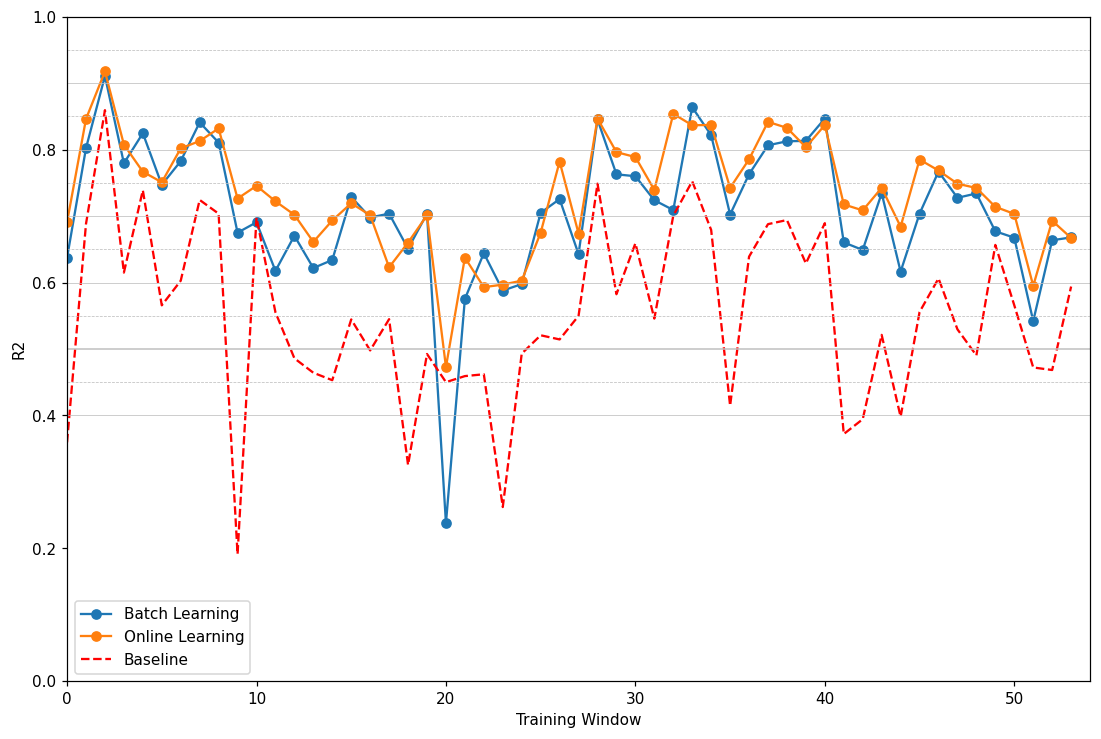

In [5]:
import matplotlib.pyplot as plt

def report_results(batch, online, base):
    plt.figure(figsize=(12, 8), dpi=110)
    plt.ylim([0, 1])
    plt.xlim([0, 54])
    plt.plot(batch, marker='o', label='Batch Learning')
    plt.plot(online, marker='o', label='Online Learning')
    plt.plot(base, color="r", linestyle="dashed", label='Baseline')
    plt.ylabel("R2")
    plt.xlabel("Training Window")
    plt.legend()
    plt.axhline(0.4, color='silver', linewidth=0.5)
    plt.axhline(0.45, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.5, color='silver', linewidth=1)
    plt.axhline(0.55, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.6, color='silver', linewidth=0.5)
    plt.axhline(0.65, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.7, color='silver', linewidth=0.5)
    plt.axhline(0.75, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.8, color='silver', linewidth=0.5)
    plt.axhline(0.85, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.9, color='silver', linewidth=0.5)
    plt.axhline(0.95, color='silver', linestyle="dashed", linewidth=0.5)
    plt.savefig(f"img/{MODEL_TYPE}_{WINDOW}.png")
    plt.show()

report_results(score_batch, score_online, score_baseline)

In [6]:
import statistics

mean_online = statistics.mean(score_online)
var_online = statistics.stdev(score_online) ** 2
mean_batch = statistics.mean(score_batch)
var_batch = statistics.stdev(score_batch) ** 2
mean_baseline = statistics.mean(score_baseline)

print(f"Online: mean({mean_online:.4f}), gain({mean_online - mean_baseline:.4f}), var({var_online:.4f}) | Batch: mean({mean_batch:.4f}), gain({mean_batch - mean_baseline:.4f}), var({var_batch:.4f})")

Online: mean(0.7358), gain(0.1826), var(0.0071) | Batch: mean(0.7091), gain(0.1560), var(0.0109)
